This notebook is to list out some of the commonly used feature selection methods. With the increasing volume of data, features can be created relatively easily. However, most of them may not be useful. Keeping the predictive features not only can speed up the training time but also help to explain the result.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# import data
df = pd.read_csv('https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/automobile.csv')

In [3]:
df.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

In [4]:
df.dtypes

symboling              int64
normalized-losses    float64
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                  int64
dtype: object

#### Data Processing

In [5]:
df.sample(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
64,-1,93.0,mercedes-benz,diesel,turbo,four,sedan,rwd,front,110.0,...,183,idi,3.58,3.64,21.5,123,4350,22,25,25552
82,1,125.0,mitsubishi,gas,std,four,sedan,fwd,front,96.3,...,122,2bbl,3.35,3.46,8.5,88,5000,25,32,6989
161,1,168.0,toyota,gas,std,two,sedan,rwd,front,94.5,...,98,mpfi,3.24,3.08,9.4,112,6600,26,29,9298
29,2,137.0,honda,gas,std,two,hatchback,fwd,front,86.6,...,92,1bbl,2.91,3.41,9.6,58,4800,49,54,6479
93,1,122.0,nissan,gas,std,four,sedan,fwd,front,94.5,...,97,2bbl,3.15,3.29,9.4,69,5200,31,37,7499


In [6]:
df.shape

(202, 26)

In [7]:
# remove rows with '?'
df = df[df['bore']!='?']
df = df[df['stroke']!='?']
df = df[df['horsepower']!='?']
df = df[df['peak-rpm']!='?']

In [8]:
# convert data type
df['bore'] = df['bore'].astype('float')
df['stroke'] = df['stroke'].astype('float')
df['horsepower'] = df['horsepower'].astype('int')
df['peak-rpm'] = df['peak-rpm'].astype('int')

In [9]:
cat_cols = df.select_dtypes(include='O').columns.to_list()
df[cat_cols] = df[cat_cols].astype('category')

In [10]:
cat_cols

['make',
 'fuel-type',
 'aspiration',
 'num-of-doors',
 'body-style',
 'drive-wheels',
 'engine-location',
 'engine-type',
 'num-of-cylinders',
 'fuel-system']

## Feature selection strategies

#### Columns with missing values

In [11]:
# total null values per column
df.isnull().sum()

symboling             0
normalized-losses    35
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  0
stroke                0
compression-ratio     0
horsepower            0
peak-rpm              0
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [12]:
# drop column
df = df.drop(['normalized-losses'], axis=1)

## Uncorrelated features

#### a) Numeric features

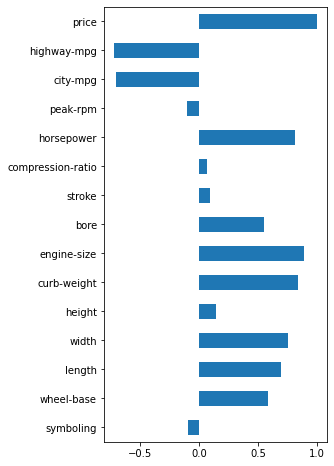

In [13]:
# correlation between y and features
(df.corr().loc['price']
 .plot(kind='barh', figsize=(4,8))) 

In [14]:
# drop numeric features  not correlation with the target (threshold <0.2)
corr = abs(df.corr().loc['price'])
corr = corr[corr<0.2]
cols_to_drop = corr.index.to_list()
df = df.drop(cols_to_drop, axis=1)

In [15]:
len(df.columns)

20

#### b) Categorical features

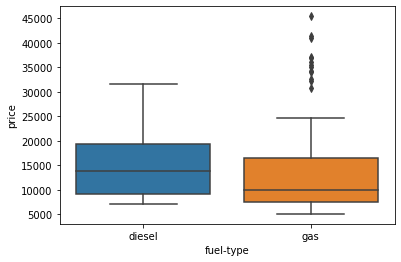

In [16]:
sns.boxplot(y = 'price', x = 'fuel-type', data=df)

#### Low varience features

In [17]:
# variance of numeric features
(df
 .select_dtypes(include=np.number)
 .var()
 .astype('str'))

wheel-base       37.94025405546827
length           155.9424623233909
width            4.570510465724747
curb-weight      275205.6007064364
engine-size      1708.835871271584
bore           0.07456791993720567
horsepower      1427.3492412349553
city-mpg         40.97485609628467
highway-mpg      46.57443746729464
price            65020222.64615383
dtype: object

In [18]:
df['bore'].describe()

count    196.000000
mean       3.331684
std        0.273071
min        2.540000
25%        3.150000
50%        3.310000
75%        3.590000
max        3.940000
Name: bore, dtype: float64

## Multicolinearity

Multicollinearity is the occurrence of high intercorrelations among two or more independent variables in a multiple regression model. Multicollinearity can lead to skewed or misleading results. Multicolinearity is less of a problem for tree based method.



#### a) Numeric features

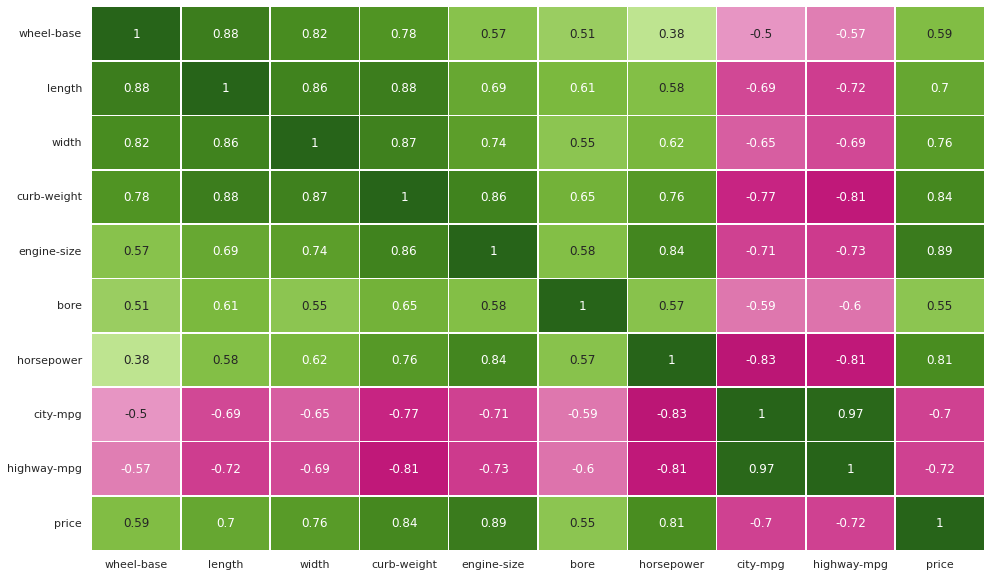

In [19]:
sns.set(rc={'figure.figsize':(16,10)})
sns.heatmap(df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="PiYG")
plt.show()

In [20]:
# drop correlated features
df = df.drop(['length', 'width', 'curb-weight', 'engine-size', 'city-mpg'], axis=1)

In [21]:
len(df.columns)

15

#### b) Categorical variables

In [22]:
df_cat = df[['fuel-type', 'body-style']]
df_cat.sample(5)

,fuel-type,body-style
86,gas,sedan
106,gas,wagon
10,gas,sedan
104,gas,sedan
2,gas,hatchback


In [23]:
crosstab = pd.crosstab(df_cat['fuel-type'], df_cat['body-style'])
crosstab

body-style,convertible,hardtop,hatchback,sedan,wagon
fuel-type,,,,,
diesel,0,1,1,15,3
gas,6,7,62,80,21


In [24]:
from scipy.stats import chi2_contingency
chi2_contingency(crosstab)

(9.205409356725148,
 0.05616535232132477,
 4,
 array([[ 0.6122449 ,  0.81632653,  6.42857143,  9.69387755,  2.44897959],
        [ 5.3877551 ,  7.18367347, 56.57142857, 85.30612245, 21.55102041]]))

## Model based feature selection

In [25]:
# drop rows with missing values
df = df.dropna()
# get dummies for categorical features
df = pd.get_dummies(df, drop_first=True)

# X features
X = df.drop('price', axis=1)

# y target
y = df['price']


# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# convert back to dataframe
X_train = pd.DataFrame(X_train, columns = X.columns.to_list())
X_test = pd.DataFrame(X_test, columns = X.columns.to_list())

#### Feature coefficients

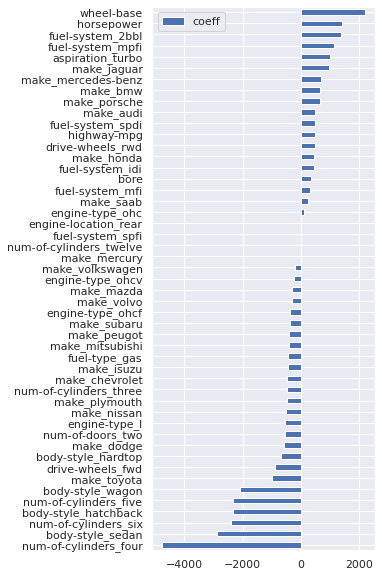

In [26]:
# instantiate model
model = LinearRegression() 

# fit
model.fit(X_train, y_train)

# feature coefficients
coeffs = model.coef_

# visualizing coefficients
index = X_train.columns.tolist()

(pd.DataFrame(coeffs, index = index, columns = ['coeff']).sort_values(by = 'coeff')
 .plot(kind='barh', figsize=(4,10)))

In [27]:
# filter variables near zero coefficient value
temp = pd.DataFrame(coeffs, index = index, columns = ['coeff']).sort_values(by = 'coeff')
temp = temp[(temp['coeff']>1) | (temp['coeff']< -1)]

# drop features
cols_coeff = temp.index.to_list()
X_train = X_train[cols_coeff]
X_test = X_test[cols_coeff]

#### P value

In [28]:
ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     62.39
Date:                Tue, 07 Jun 2022   Prob (F-statistic):           2.82e-76
Time:                        03:50:43   Log-Likelihood:                -1727.5
No. Observations:                 194   AIC:                             3549.
Df Residuals:                     147   BIC:                             3703.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
wheel-base                

#### Variance Inflation Factor (VIF)

The variance inflation factor (VIF) is the ratio (quotient) of the variance of estimating some parameter in a model that includes multiple other terms (parameters) by the variance of a model constructed using only one term. It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity.

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [30]:
index = X_train.columns.tolist()
vif_df = pd.DataFrame(vif, index = index, columns = ['vif']).sort_values(by = 'vif', ascending=False)
vif_df[vif_df['vif']<10]

,vif
engine-type_ohc,9.832494
body-style_wagon,9.788068
make_mitsubishi,9.725685
highway-mpg,9.344857
wheel-base,8.932013
fuel-system_spdi,8.894106
make_bmw,8.729793
make_volkswagen,8.326544
make_mazda,8.291162
make_porsche,7.522600


## Feature importance/impurity based feature selection using  Random Forest Model

In [31]:
# instantiate model
model = RandomForestClassifier(n_estimators=200, random_state=0)
# fit model
model.fit(X,y)

RandomForestClassifier(n_estimators=200, random_state=0)

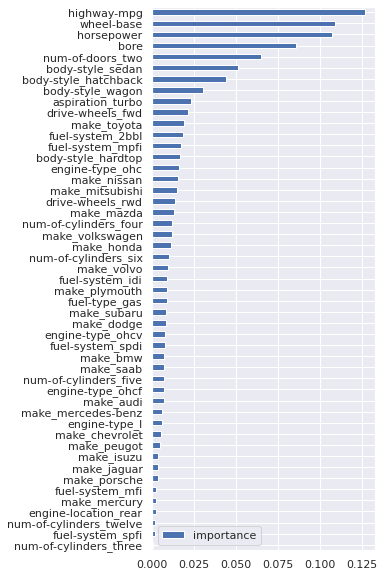

In [32]:
#  feature importance
importances = model.feature_importances_

# visualization
cols = X.columns
(pd.DataFrame(importances, cols, columns = ['importance'])
 .sort_values(by='importance', ascending=True)
 .plot(kind='barh', figsize=(4,10))
);

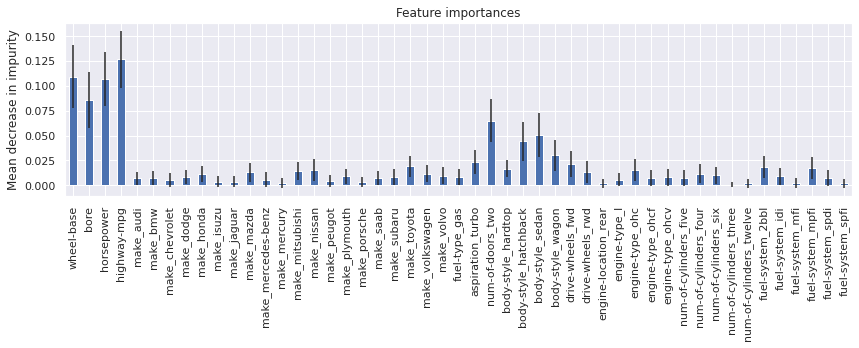

In [33]:
# calculate standard deviation of feature importances 
std = np.std([i.feature_importances_ for i in model.estimators_], axis=0)

# visualization
feat_with_importance  = pd.Series(importances, X.columns)
fig, ax = plt.subplots(figsize=(12,5))
feat_with_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Automated feature selection with sci-kit learn

In [34]:
# import modules
from sklearn.feature_selection import (SelectKBest, chi2, SelectPercentile, SelectFromModel, 
                                       SequentialFeatureSelector, SequentialFeatureSelector)
                                       

#### Chi-squared based technique

In [35]:
# select K best features
X_best = SelectKBest(chi2, k=10).fit_transform(X,y) 
# number of best features
X_best.shape[1]

10

In [36]:
# keep 75% top features 
X_top = SelectPercentile(chi2, percentile = 75).fit_transform(X,y)

# number of best features
X_top.shape[1]

36

####  Sequential selection

In [ ]:
# instantiate model
model = RandomForestClassifier(n_estimators=100, random_state=0)
# select features
selector = SequentialFeatureSelector(estimator=model, n_features_to_select=10, direction='backward', cv=2)

selector.fit_transform(X,y)

# names of features selected
feature_names = np.array(X.columns)
feature_names[selector.get_support()]

In [38]:
feature_names

array(['wheel-base', 'bore', 'horsepower', 'highway-mpg', 'make_audi',
       'make_bmw', 'make_chevrolet', 'make_dodge', 'make_honda',
       'make_isuzu', 'make_jaguar', 'make_mazda', 'make_mercedes-benz',
       'make_mercury', 'make_mitsubishi', 'make_nissan', 'make_peugot',
       'make_plymouth', 'make_porsche', 'make_saab', 'make_subaru',
       'make_toyota', 'make_volkswagen', 'make_volvo', 'fuel-type_gas',
       'aspiration_turbo', 'num-of-doors_two', 'body-style_hardtop',
       'body-style_hatchback', 'body-style_sedan', 'body-style_wagon',
       'drive-wheels_fwd', 'drive-wheels_rwd', 'engine-location_rear',
       'engine-type_l', 'engine-type_ohc', 'engine-type_ohcf',
       'engine-type_ohcv', 'num-of-cylinders_five',
       'num-of-cylinders_four', 'num-of-cylinders_six',
       'num-of-cylinders_three', 'num-of-cylinders_twelve',
       'fuel-system_2bbl', 'fuel-system_idi', 'fuel-system_mfi',
       'fuel-system_mpfi', 'fuel-system_spdi', 'fuel-system_spfi'],
     

#### Principal Compoenent Analysis (PCA)

In [39]:
from sklearn.decomposition import PCA

In [40]:
# scaling data
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)
evr = pca.explained_variance_ratio_

Text(0, 0.5, 'Cumulative explained variance')

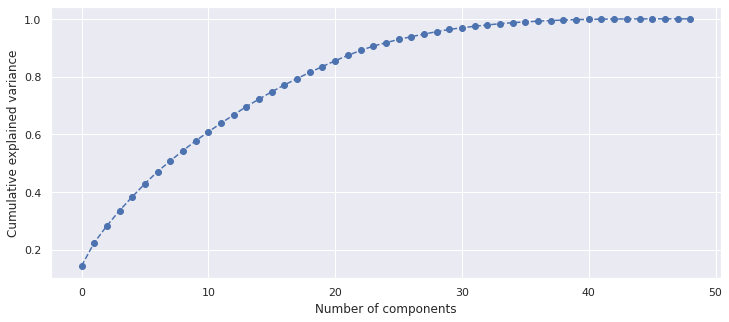

In [41]:
# visualizing the variance explained by each principal components

plt.figure(figsize=(12, 5))
plt.plot(range(0, len(evr)), evr.cumsum(), marker="o", linestyle="--")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")